# 1. Dataset Loading and Environment Setup

In [1]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [2]:
!gdown 18d8LMm61ddRcHLvbncBJjxkA4LijFT-k
!gdown 1dY2Rvck-rsmyuqrciHLsteRurfptK9De
!gdown 1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb

Downloading...
From: https://drive.google.com/uc?id=18d8LMm61ddRcHLvbncBJjxkA4LijFT-k
To: /content/train.csv
100% 6.25M/6.25M [00:00<00:00, 44.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dY2Rvck-rsmyuqrciHLsteRurfptK9De
To: /content/dev.csv
100% 816k/816k [00:00<00:00, 79.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1DI9mDSCfOZUc6FIwSdIo7KQPXmz3tYAb
To: /content/test.csv
100% 777k/777k [00:00<00:00, 30.6MB/s]


In [3]:
%%capture
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate
!pip install evaluate
!pip install datsets transformers[sentencepiece]
!pip install sentencepiece
!pip install rouge-score
!pip install bert_score

In [4]:
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from collections import defaultdict
from rouge_score import rouge_scorer
from evaluate import load
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_id = 0 if str(device) == 'cuda' else -1

In [5]:
train_df = pd.read_csv('train.csv')
dev_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

In [6]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# 2. Data Analysis
We want to see the distribution of review token lengths and summary token lengths to decide the max length to impose on our model

In [7]:
# Lists to store token lengths
review_lengths = []
summary_lengths = []
reviews = train_df['reviewText']
summaries = train_df['summary']
# Calculate token lengths for reviews
for review in reviews:
    tokenized_review = tokenizer.encode(review)
    review_lengths.append(len(tokenized_review))

# Calculate token lengths for summaries
for summary in summaries:
    tokenized_summary = tokenizer.encode(summary)
    summary_lengths.append(len(tokenized_summary))

Token indices sequence length is longer than the specified maximum sequence length for this model (1326 > 512). Running this sequence through the model will result in indexing errors


In [8]:
pd.Series(review_lengths).describe()

count    11095.000000
mean       113.610635
std        190.065215
min          2.000000
25%         30.000000
50%         55.000000
75%        123.000000
max       6677.000000
dtype: float64

In [9]:
pd.Series(summary_lengths).describe()

count    11095.000000
mean         8.807391
std          5.122436
min          2.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         70.000000
dtype: float64

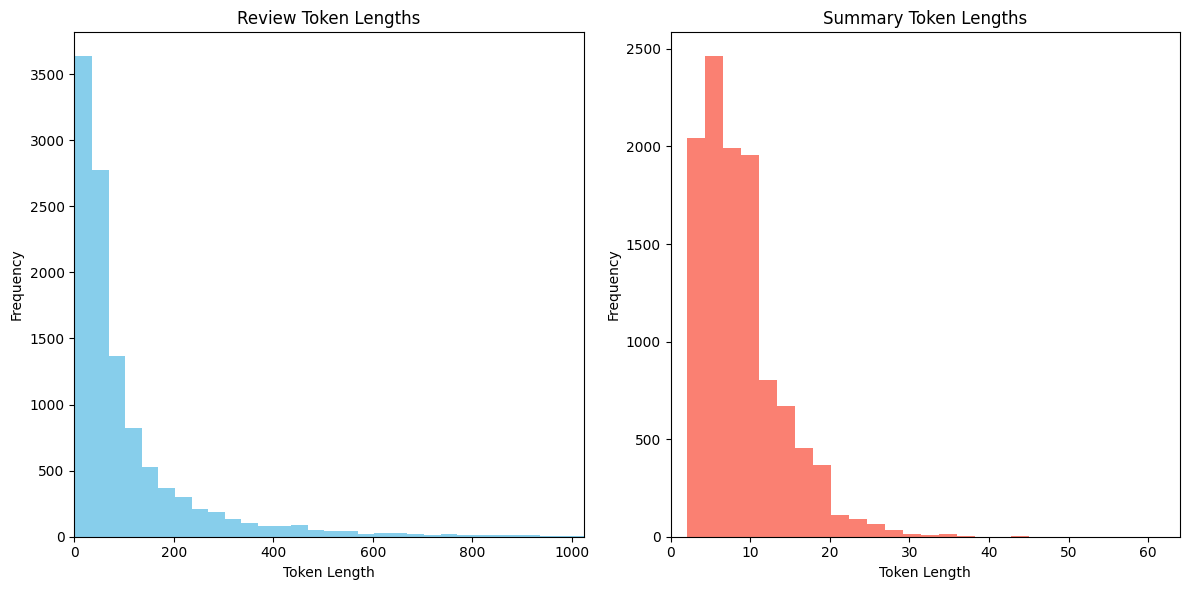

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of review token lengths
axs[0].hist(review_lengths, bins=200, color='skyblue')

axs[0].set_title('Review Token Lengths')
axs[0].set_xlabel('Token Length')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 1024)

# Plot distribution of summary token lengths
axs[1].hist(summary_lengths, bins=30, color='salmon')
axs[1].set_title('Summary Token Lengths')
axs[1].set_xlabel('Token Length')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(0, 64)

plt.tight_layout()
plt.show()

In [ ]:
train_df['summarize_prompt'] = train_df.apply(lambda x: 'summarize: ' + x['reviewText'], axis=1)
dev_df['summarize_prompt']   = dev_df.apply(lambda x: 'summarize: ' + x['reviewText'], axis=1)
test_df['summarize_prompt']  = test_df.apply(lambda x: 'summarize: ' + x['reviewText'], axis=1)

# 3. Creating a Custom Dataset

In [ ]:
class SummarizationDataset(Dataset):
    def __init__(self, input_ids, target_ids):
        self.input_ids = input_ids
        self.target_ids = target_ids

    def __len__(self):
        return len(self.input_ids['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids['input_ids'][idx],
            'attention_mask': self.input_ids['attention_mask'][idx],
            'labels': self.target_ids['input_ids'][idx]
        }

Since most reviews are under 256 tokens, we will set that as our maximum review length and truncate the rest of the review. Since most of the summary lengths are under 32 tokens, we will set the maximum review length to be 32

In [ ]:
MAX_INPUT_LEN = 256
MAX_OUTPUT_LEN = 32

In [ ]:
def make_summarization_dataset(df):
  input_ids = tokenizer(df['summarize_prompt'].tolist(), return_tensors='pt', max_length=MAX_INPUT_LEN, truncation=True, padding=True)
  target_ids = tokenizer(df['summary'].tolist(), return_tensors='pt', max_length=MAX_OUTPUT_LEN, truncation=True, padding=True)
  return SummarizationDataset(input_ids, target_ids)

In [ ]:
train_dataset = make_summarization_dataset(train_df)
eval_dataset = make_summarization_dataset(dev_df)
test_dataset = make_summarization_dataset(test_df)

In [ ]:
print(len(train_dataset))
print(len(eval_dataset))
print(len(test_dataset))

11095
1387
1388


# 4. Model Training

In [ ]:
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 1e-4

In [ ]:
trainer_args = TrainingArguments(
    evaluation_strategy='epoch',
    logging_strategy="epoch",
    output_dir='t5-training',
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    load_best_model_at_end=True,
    save_strategy = "epoch"
)

trainer = Trainer(model=model,
                  args=trainer_args,
                  train_dataset=train_dataset,
                  eval_dataset=eval_dataset)

In [ ]:
trainer.train()
trainer.save_model('./t5_model')

Epoch,Training Loss,Validation Loss
1,1.602100,0.858558
2,0.876100,0.839673
3,0.853400,0.833232
4,0.842300,0.830028
5,0.836400,0.829299


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


In [ ]:
epochs = np.arange(1, EPOCHS+1)
eval_loss = [trainer.state.log_history[1 + i * 2]['eval_loss'] for i in range(0, EPOCHS)]
train_loss = [trainer.state.log_history[i * 2]['loss'] for i in range(0, EPOCHS)]

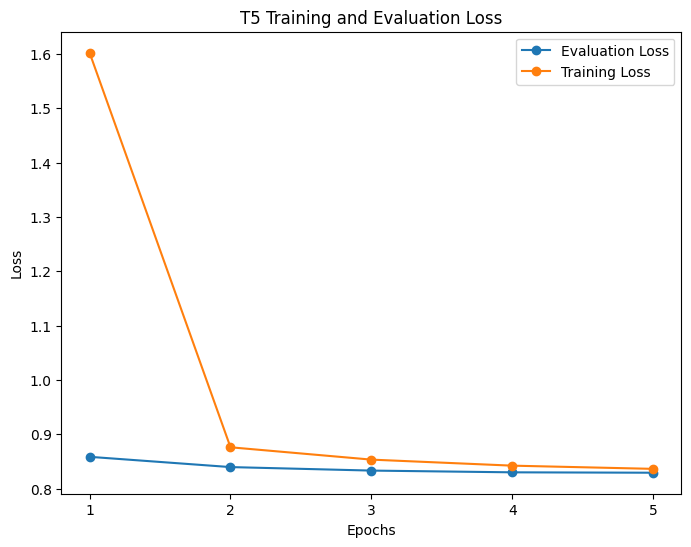

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(epochs, eval_loss, label='Evaluation Loss', marker='o')
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.title('T5 Training and Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

# 5. Evaluation

## 5.1 Generate Results
We first generate the results of our model for each of our datasets

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('/content/t5_model')
model = model.to(device)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
dev_loader = DataLoader(eval_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
NUM_BEAMS = 8
def generate_summary(dataloader):
  summaries = []
  for batch in dataloader:
    input_ids = batch['input_ids']
    attention_masks = batch['attention_mask']
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)

    encoded_summaries = model.generate(
          input_ids=input_ids,
          attention_mask=attention_masks,
          max_length=MAX_OUTPUT_LEN,
          num_beams=NUM_BEAMS,
          early_stopping=True
      )
    decoded_summaries = tokenizer.batch_decode(encoded_summaries, skip_special_tokens=True)
    summaries.extend(decoded_summaries)
  return summaries

In [ ]:
train_predictions = generate_summary(train_loader)
dev_predictions = generate_summary(dev_loader)
test_predictions = generate_summary(test_loader)

In [ ]:
train_references = train_df['summary']
dev_references = dev_df['summary']
test_references = test_df['summary']

## 5.2 Evaluation Metrics
We will use both rouge_score and bert_score for our evaluation metrics. We will specifically be looking at the averaged f1 scores of both metrics.

In [ ]:
def rouge_score(prediction, reference):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(prediction, reference)
    return scores

In [ ]:
def evaluate_rouge(predictions, references):
  rouge1_f = 0
  rouge2_f = 0
  rougeL_f = 0

  num_reviews = len(predictions)
  for pred, actual in zip(predictions, references):
    scores = rouge_score(pred, actual)
    rouge1_f += scores['rouge1'][2]
    rouge2_f += scores['rouge2'][2]
    rougeL_f += scores['rougeL'][2]

  rouge1_f = rouge1_f / num_reviews
  rouge2_f = rouge2_f / num_reviews
  rougeL_f = rougeL_f / num_reviews

  return (rouge1_f, rouge2_f, rougeL_f)

In [ ]:
bertscore = load("bertscore")
def evaluate_bert(predictions, references):
  results = bertscore.compute(predictions=predictions,
                              references=references,
                              rescale_with_baseline=True,
                              lang='en')
  f1_scores = results['f1']
  if len(f1_scores) == 0:
    return None

  return sum(f1_scores) / len(f1_scores)


## 5.3 Evaluate Results

In [ ]:
print("Training Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(train_predictions, train_references)
bert_f = evaluate_bert(train_predictions, train_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)
print("-------------")
print("Dev Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(dev_predictions, dev_references)
bert_f = evaluate_bert(dev_predictions, dev_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)
print("-------------")
print("Test Eval")
rouge1_f, rouge2_f, rougeL_f = evaluate_rouge(test_predictions, test_references)
bert_f = evaluate_bert(test_predictions, test_references)
print("ROUGE-1 F-Score: ", rouge1_f)
print("ROUGE-2 F-Score: ", rouge2_f)
print("ROUGE-L F-Score: ", rougeL_f)
print("Bert F-Score: ", bert_f)

Training Eval


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ROUGE-1 F-Score:  0.20447826813267933
ROUGE-2 F-Score:  0.11554647171432439
ROUGE-L F-Score:  0.19808721106634697
Bert F-Score:  0.16099470961998244
-------------
Dev Eval
ROUGE-1 F-Score:  0.20934658017686733
ROUGE-2 F-Score:  0.11682106720701764
ROUGE-L F-Score:  0.20454272674160565
Bert F-Score:  0.1617780305560151
-------------
Test Eval
ROUGE-1 F-Score:  0.20885994422506673
ROUGE-2 F-Score:  0.11906354130939163
ROUGE-L F-Score:  0.2017694773367149
Bert F-Score:  0.1632421246969835


# 6. Save Results

In [ ]:
def write_to_file(data, file_name):
    with open(file_name, 'w') as txtfile:
        for row in data:
            txtfile.write(str(row) + '\n')

In [ ]:
write_to_file(dev_predictions, 'strong_dev_pred.txt')
write_to_file(dev_references, 'strong_dev_ref.txt')

In [ ]:
write_to_file(test_predictions, 'strong_test_pred.txt')
write_to_file(test_references, 'strong_test_ref.txt')

In [ ]:
write_to_file(train_predictions, 'strong_train_pred.txt')
write_to_file(train_references, 'strong_train_ref.txt')